### SETUP INICIAL DO PROJETO

In [9]:

#importação das bibliotecase e pacotes necessários para a análise

import json
import numpy as np
import os
import pandas as pd
import pandas_gbq as gbq
import re
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from google.cloud import bigquery
from google.cloud.bigquery_storage import BigQueryReadClient
from google.oauth2 import service_account


# Carrega o .env: onde estão as credenciais do projeto/repositório
load_dotenv("/mnt/c/Users/wrpen/OneDrive/Desktop/df_lh/.env")

# Detectar ambiente: como eu estou usando wsl-ubuntu, no VS Code  -  Windows, estava dando conflitos de path
if os.name == "nt":  # se Windows
    credentials_path = r"C:\Temp\desafiolh-445818-3cb0f62cb9ef.json"
else:  # se WSL/Linux
    credentials_path = "/mnt/c/Temp/desafiolh-445818-3cb0f62cb9ef.json"

# Parâmetros injetados pelo Papermill ou definidos manualmente, caso não existam no ambiente
# Tables_to_process: lista de tabelas que serão processadas
# Output_dataset: nome do dataset onde os dados processados serão armazenados, neste caso, raw_data_cleaned
if 'tables_to_process' not in locals():
    tables_to_process = [
        "desafioadventureworks-446600.stg_marts_tables.dim_product_forecast"  ,
        "desafioadventureworks-446600.stg_marts_tables.dim_product_seasonality",
        "desafioadventureworks-446600.stg_staging_tables.stg_production_product",
        "desafioadventureworks-446600.stg_staging_tables.stg_sales_store"

    ]

if 'output_dataset' not in locals():
    output_dataset = "desafioadventureworks-446600.stg_marts_tables"

# Configs do cliente BigQuery: input de project e location de acordo com dados no Bigquery
credentials = service_account.Credentials.from_service_account_file(credentials_path)
client = bigquery.Client(credentials=credentials, project=os.getenv("BIGQUERY_PROJECT"), location="us-central1")


In [10]:
# Print com a tabela que vai ser processada nesse notebook

print("Tabelas a processar:", tables_to_process)

Tabelas a processar: ['desafioadventureworks-446600.stg_marts_tables.dim_product_forecast', 'desafioadventureworks-446600.stg_marts_tables.dim_product_seasonality', 'desafioadventureworks-446600.stg_staging_tables.stg_production_product', 'desafioadventureworks-446600.stg_staging_tables.stg_sales_store']


# Exploratory Data Analysis (EDA) e Data Cleaning

### Glossário dos dados:

O termo ''doc:'', situado no rodapé de algumas cells, indica algo como:

- documentação: documentar decisões, análises e resultados;

- abreviações de termos, como bkp, df, entre outros.

In [11]:
# Configuração para que o df exiba todas as colunas e todas as linhas completas, e também, exiba o formato numérico com 2 dígitos após a vírgula

pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 10000)
pd.options.display.float_format = '{:.2f}'.format


#doc: df = dataframe  

In [12]:
# Dicionário para armazenar os df processados
df_processados = {}

# Iteração das tabelas e armazenamento em df
for input_table in tables_to_process:
    print(f"Processando tabela: {input_table}")
    
    # Nome da tabela com substituição de '-' por '_'
    table_name = input_table.split(".")[-1].replace("-", "_")  
    
    # Ler os dados da tabela do BigQuery para um df
    print("Lendo os dados do BigQuery...")
    query = f"SELECT * FROM `{input_table}`"
    table_data = client.query(query).to_dataframe()
    
    # Armazenar o df no dicionário
    df_processados[table_name] = table_data
    print(f"Tabela {table_name} processada e armazenada com sucesso.")

# Print de validação
print("Todas as tabelas foram processadas com sucesso!")


Processando tabela: desafioadventureworks-446600.stg_marts_tables.dim_product_forecast
Lendo os dados do BigQuery...
Tabela dim_product_forecast processada e armazenada com sucesso.
Processando tabela: desafioadventureworks-446600.stg_marts_tables.dim_product_seasonality
Lendo os dados do BigQuery...
Tabela dim_product_seasonality processada e armazenada com sucesso.
Processando tabela: desafioadventureworks-446600.stg_staging_tables.stg_production_product
Lendo os dados do BigQuery...
Tabela stg_production_product processada e armazenada com sucesso.
Processando tabela: desafioadventureworks-446600.stg_staging_tables.stg_sales_store
Lendo os dados do BigQuery...
Tabela stg_sales_store processada e armazenada com sucesso.
Todas as tabelas foram processadas com sucesso!


In [13]:
# Listar todas as variáveis criadas dinamicamente
for table_name in df_processados.keys():
    print(f"Variável criada: {table_name}")  

Variável criada: dim_product_forecast
Variável criada: dim_product_seasonality
Variável criada: stg_production_product
Variável criada: stg_sales_store


In [14]:
# # Realizar merge entre dim_product_forecast e stg_production_product para incluir o nome do produto
# consolidated_df = df_processados['dim_product_forecast'].merge(
#     df_processados['stg_production_product'][['productid_id', 'product_nm']],
#     how='left',
#     on='productid_id'
# )

# # Realizar merge com stg_sales_store usando 'businessentityid_id' como chave
# consolidated_df = consolidated_df.merge(
#     df_processados['stg_sales_store'][['businessentityid_id', 'store_nm']],
#     how='left',
#     left_on='storeid_id',
#     right_on='businessentityid_id'
# )

# # Se necessário, realizar merge com outras tabelas (exemplo: sazonalidade)
# consolidated_df = consolidated_df.merge(
#     df_processados['dim_product_seasonality'],
#     how='left',
#     on=['productid_id', 'storeid_id']
# )

# # Visualizar as primeiras linhas para verificar a consolidação
# print(consolidated_df.head())


In [15]:
# Atribuir o df a uma variável com nome mais simples
dim_product_forecast = df_processados['dim_product_forecast']

print(f"Colunas: {dim_product_forecast.shape[1]}\nLinhas: {dim_product_forecast.shape[0]}")

Colunas: 4
Linhas: 106840


In [16]:
# Ordenar e exibir o df por 'productid_id'
dim_product_forecast = dim_product_forecast.sort_values(by=['productid_id'])

print(dim_product_forecast)

       store_id  productid_id forecast_date  forecast_quantity
97378        10           707    2025-01-07            2180.00
61195         6           707    2025-04-07            4636.00
7023          1           707    2025-03-07            2756.00
7022          1           707    2025-03-07            2756.00
98748        10           707    2025-02-07            2180.00
...         ...           ...           ...                ...
50410         5           999    2025-04-07             392.00
67555         6           999    2025-03-07             692.00
79787         7           999    2025-04-07             444.00
50144         5           999    2025-04-07             392.00
90456         9           999    2025-04-07             412.00

[106840 rows x 4 columns]


In [17]:
# Iterar por todas as colunas do df, para verificar valores ausentes

# Verificar valores ausentes na coluna
for column in dim_product_forecast.columns:   
    missing_rows = dim_product_forecast[dim_product_forecast[column].isnull()]
    print(f"Coluna '{column}': {missing_rows.shape[0]} linhas ausentes.")
    
# Mostrar as primeiras linhas ausentes, se preciso for, limitar o head() para dar menos outputs ou limitar os outputs
    if not missing_rows.empty:
        print(f"Exibindo as primeiras linhas com valores ausentes em '{column}':")
        print(missing_rows.head(), "\n")
    else:
        print(f"Nenhuma linha com valores ausentes em '{column}'.\n")

Coluna 'store_id': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'store_id'.

Coluna 'productid_id': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'productid_id'.

Coluna 'forecast_date': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'forecast_date'.

Coluna 'forecast_quantity': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'forecast_quantity'.



In [18]:
# Valores únicos por coluna, para verificar se colunas como flags, normalmente booleanas, possuem apenas 1 ou 2 valores.

valores_unicos = dim_product_forecast.nunique(dropna=False)

print("Valores únicos incluindo NaN:")
print(valores_unicos)

#doc: currentflag possue somente 1 valor, o que indica que pode ser somente valores True ou False.

Valores únicos incluindo NaN:
store_id              10
productid_id         266
forecast_date          4
forecast_quantity    436
dtype: int64


In [19]:
#verificar informações do df
dim_product_forecast.info()

<class 'pandas.core.frame.DataFrame'>
Index: 106840 entries, 97378 to 90456
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   store_id           106840 non-null  Int64  
 1   productid_id       106840 non-null  Int64  
 2   forecast_date      106840 non-null  dbdate 
 3   forecast_quantity  106840 non-null  float64
dtypes: Int64(2), dbdate(1), float64(1)
memory usage: 4.3 MB


In [20]:
#Visão Geral da Previsão: 

# Total de demanda por loja*

demand_by_store = dim_product_forecast.groupby('store_id')['forecast_quantity'].sum().reset_index()
demand_by_store = demand_by_store.sort_values(by='forecast_quantity', ascending=False)

print(demand_by_store.head(15))


#doc*: soma da previsão de demanda agrupada por loja


# Conclusões sobre a previsão de demanda por loja:

# 1. A loja com o ID 4 possui a maior previsão de demanda (17,850,928.00), indicando ser a principal 
#    consumidora de produtos nos próximos 3 meses. Isso sugere que ela deve receber maior atenção
#    na distribuição de produtos e planejamento de estoque.

# 2. A loja com o ID 6 é a segunda maior em previsão de demanda (14,796,192.00), também se destacando
#    como um centro importante para alocação de produtos.

# 3. As lojas com IDs 1, 10 e 2 completam o top 5, apresentando demandas significativamente menores,
#    mas ainda consideráveis. Estas lojas podem ser consideradas secundárias em termos de prioridade.

# 4. A diferença entre as lojas com maior (ID 4) e menor (ID 8) demanda no top 10 é de aproximadamente
#    15,184,704 unidades. Isso mostra uma concentração de demanda em certas lojas.

# 5. O padrão de demanda evidencia que os esforços logísticos e de distribuição devem ser direcionados
#    para lojas de alta demanda (principalmente IDs 4 e 6), enquanto as demais podem ser monitoradas
#    com menos frequência.


   store_id  forecast_quantity
3         4        17850928.00
5         6        14796192.00
0         1         9948192.00
9        10         5013312.00
1         2         5011984.00
2         3         4870256.00
4         5         4868928.00
6         7         4623568.00
8         9         4058496.00
7         8         2676224.00


C:\Users\wrpen\AppData\Local\Temp\ipykernel_6808\138501806.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=demand_by_store, x='store_id', y='forecast_quantity', palette='Blues_d')


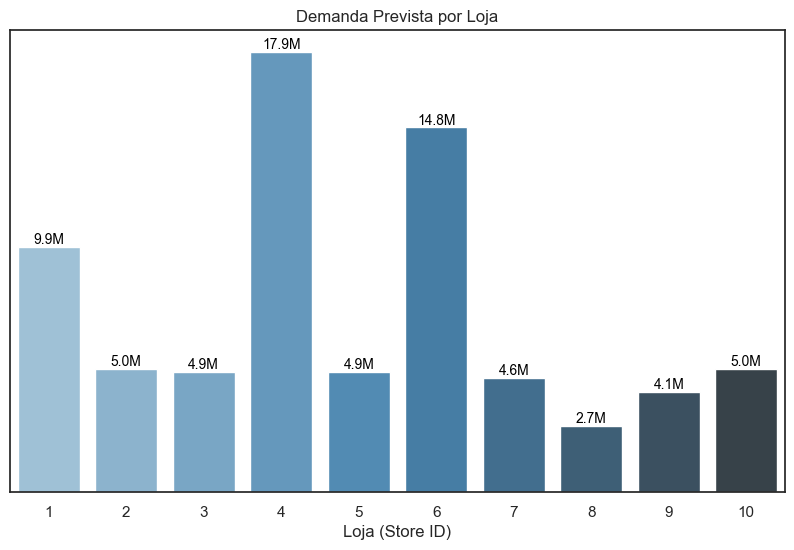

In [21]:
# Gráfico ajustado de barras para lojas sem valores no eixo Y e com valores no topo das barras

sns.set(style="white")  # Fundo branco
plt.figure(figsize=(10, 6))  # Ajustar o tamanho do gráfico

sns.barplot(data=demand_by_store, x='store_id', y='forecast_quantity', palette='Blues_d')
plt.title('Demanda Prevista por Loja')
plt.xlabel('Loja (Store ID)')
plt.ylabel('')  # Remover o rótulo do eixo Y

# Remover valores do eixo Y
plt.gca().yaxis.set_ticks([])

# Adicionar valores no topo das barras com uma casa decimal
for index, row in demand_by_store.iterrows():
    plt.text(
        x=index, 
        y=row['forecast_quantity'], 
        s=f"{row['forecast_quantity']/1000000:.1f}M", 
        ha='center', 
        va='bottom', 
        fontsize=10, 
        color='black'
    )

plt.show()


In [22]:
#Total de demanda por produto*:

demand_by_product = dim_product_forecast.groupby('productid_id')['forecast_quantity'].sum().reset_index()
demand_by_product = demand_by_product.sort_values(by='forecast_quantity', ascending=False)

print(demand_by_product.head(10))




# Conclusões sobre a previsão de demanda por produto:

# 1. O produto com ID 712 possui a maior previsão de demanda (3,996,816.00), indicando que ele será o mais requisitado
#    entre todos os produtos nos próximos 3 meses. Este produto deve ser priorizado na produção e reposição.

# 2. O produto com ID 715 é o segundo em previsão de demanda (3,291,088.00), seguido pelos IDs 711 (3,199,136.00),
#    708 (3,066,240.00) e 707 (2,890,224.00). Esses produtos compõem o top 5 em demanda prevista.

# 3. A diferença entre o produto mais demandado (ID 712) e o quinto mais demandado (ID 707) é de aproximadamente
#    1,106,592.00 unidades, indicando uma concentração de demanda significativa nos produtos mais procurados.

# 4. A presença de produtos com alta demanda relativamente próxima indica que esses itens precisam ser monitorados
#    como um grupo prioritário para ajustes em produção e estoque, dependendo das vendas reais.

# 5. Produtos fora do top 5, como o ID 714 (1,729,872.00), ainda apresentam volumes consideráveis de demanda,
#    mas podem ser considerados de prioridade secundária em um cenário de otimização de recursos.

#doc: os dados são baseados em previsões de demanda nos próximos 3 meses, agrupados por produto.




     productid_id  forecast_quantity
5             712         3996816.00
8             715         3291088.00
4             711         3199136.00
1             708         3066240.00
0             707         2890224.00
7             714         1729872.00
139           870         1505712.00
9             716         1402208.00
128           859         1263552.00
65            782         1127536.00


C:\Users\wrpen\AppData\Local\Temp\ipykernel_6808\884621614.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


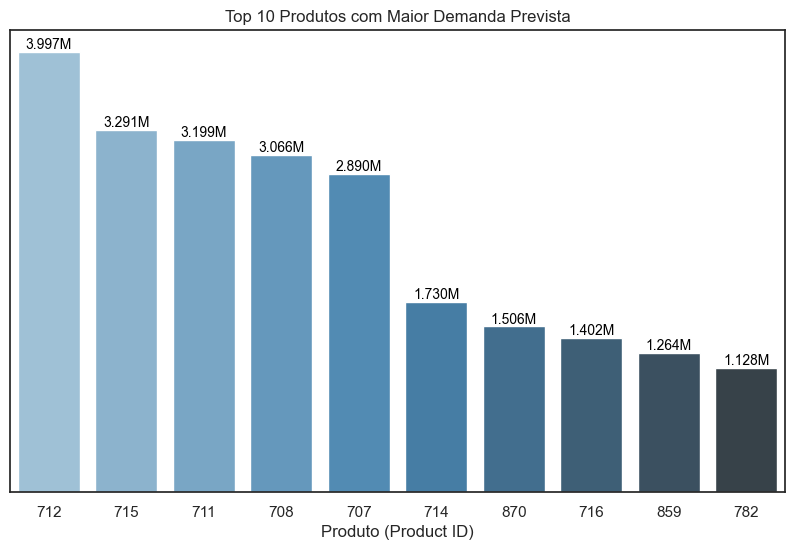

In [23]:
# Ajustar estilo do gráfico
sns.set(style="white")  # Fundo branco
plt.figure(figsize=(10, 6))  # Ajustar o tamanho do gráfico

# Selecionar apenas os Top 10 produtos com maior demanda
top_products = demand_by_product.sort_values(by='forecast_quantity', ascending=False).head(10)

# Gráfico de barras verticais para produtos com ordenação
ax = sns.barplot(
    data=top_products, 
    x='productid_id', 
    y='forecast_quantity', 
    palette='Blues_d',
    order=top_products['productid_id']
)

plt.title('Top 10 Produtos com Maior Demanda Prevista')
plt.xlabel('Produto (Product ID)')
plt.ylabel('')  # Remover o rótulo do eixo Y

# Remover valores do eixo Y
plt.gca().yaxis.set_ticks([])

# Adicionar valores no topo das barras com uma casa decimal
for bar in ax.patches:
    ax.text(
        x=bar.get_x() + bar.get_width() / 2, 
        y=bar.get_height(), 
        s=f"{bar.get_height() / 1000000:.3f}M", 
        ha='center', 
        va='bottom', 
        fontsize=10, 
        color='black'
    )

plt.show()


## Sazonalidade - Produto ID == 712

In [24]:
# Atribuir o df a uma variável com nome mais simples
dim_product_seasonality = df_processados['dim_product_seasonality']

print(f"Colunas: {dim_product_seasonality.shape[1]}\nLinhas: {dim_product_seasonality.shape[0]}")

Colunas: 5
Linhas: 35


In [25]:
dim_product_seasonality.head()

,year_month,year,month,productid_id,total_quantity_sold
0,2011-05,2011,5,712,40
1,2011-07,2011,7,712,103
2,2011-08,2011,8,712,137
3,2011-10,2011,10,712,240
4,2011-12,2011,12,712,25


In [27]:
# Atribuir o df a uma variável com nome mais simples
stg_production_product = df_processados['stg_production_product']

print(f"Colunas: {stg_production_product.shape[1]}\nLinhas: {stg_production_product.shape[0]}")

Colunas: 24
Linhas: 504


In [28]:
# Fazer o merge para adicionar o nome do produto
dim_product_seasonality = dim_product_seasonality.merge(
    stg_production_product, 
    how='left', 
    on='productid_id'
)

# Garantir que o produto com ID 712 está correto
product_name = dim_product_seasonality[dim_product_seasonality['productid_id'] == 712]['product_nm'].iloc[0]


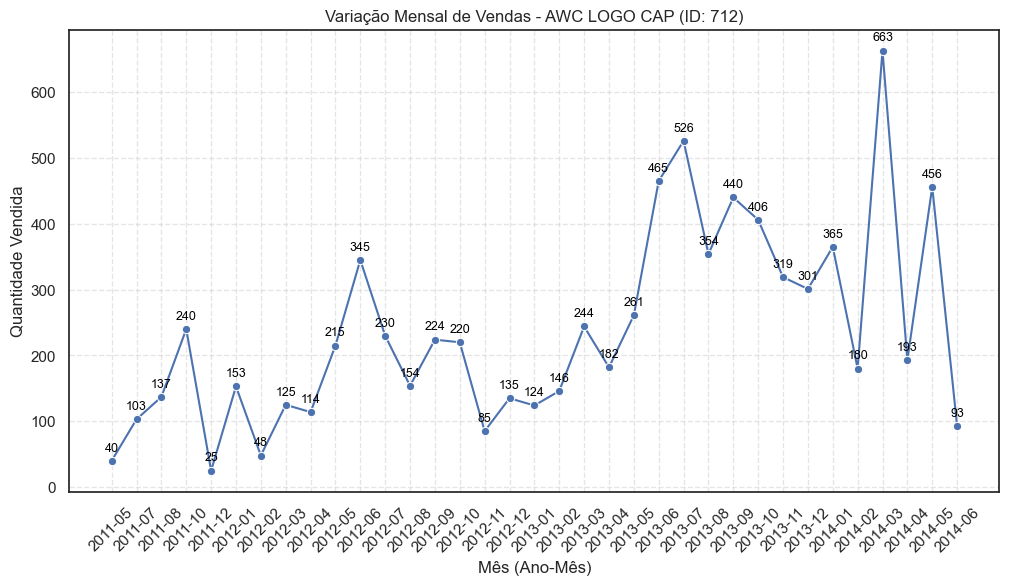

In [36]:
# Filtrar os dados para o produto 712
filtered_product = dim_product_seasonality[dim_product_seasonality['productid_id'] == 712]

# Obter o nome do produto (garantir que ele existe no merge)
product_name = filtered_product['product_nm'].iloc[0] if not filtered_product.empty else "Desconhecido"

# Criar uma coluna 'sale_month' para exibição no gráfico
filtered_product['sale_month'] = filtered_product['year'].astype(str) + '-' + filtered_product['month'].astype(str).str.zfill(2)

# Agrupar por 'sale_month' e somar a quantidade total vendida
monthly_sales = filtered_product.groupby('sale_month')['total_quantity_sold'].sum().reset_index()

# Ordenar os meses para garantir a sequência correta
monthly_sales = monthly_sales.sort_values(by='sale_month')

# Visualizar os dados em um gráfico de linhas com valores nos marcadores
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales, x='sale_month', y='total_quantity_sold', marker='o')

plt.title(f'Variação Mensal de Vendas - {product_name} (ID: 712)')
plt.xlabel('Mês (Ano-Mês)')
plt.ylabel('Quantidade Vendida')
plt.xticks(rotation=45)  # Rotacionar os rótulos para melhor leitura
plt.grid(visible=True, linestyle='--', alpha=0.5)

# Adicionar os valores nos marcadores
for i, row in monthly_sales.iterrows():
    plt.text(
        x=row['sale_month'], 
        y=row['total_quantity_sold'] + 15,  # Ajustar a posição acima do marcador
        s=row['total_quantity_sold'], 
        ha='center', 
        fontsize=9, 
        color='black'
    )

plt.show()

In [ ]:
# Conclusões sobre o gráfico de sazonalidade:

# 1. O produto analisado é o "AWC LOGO CAP" (ID: 712).
#    Este produto apresenta uma variação considerável na quantidade de vendas ao longo dos meses.

# 2. Períodos de alta:
#    - Observa-se um pico significativo de vendas em maio de 2013, alcançando 663 unidades.
#    - Outros meses de destaque incluem junho de 2012 e junho de 2013, que também apresentam volumes elevados.

# 3. Períodos de baixa:
#    - Os meses de dezembro de 2011 e fevereiro de 2014 têm os volumes mais baixos, com 25 e 93 unidades vendidas, respectivamente.
#    - É possível observar quedas acentuadas após os picos, indicando uma sazonalidade cíclica.

# 4. Tendência sazonal:
#    - O padrão de vendas sugere um comportamento sazonal com picos frequentes em meses próximos ao meio do ano (maio e junho).
#    - Esses padrões podem estar relacionados a eventos sazonais, promoções ou alta demanda típica nesses períodos.

# 5. Implicações para o planejamento:
#    - A sazonalidade identificada indica que a produção e o estoque devem ser aumentados nos meses de alta demanda (maio-junho).
#    - Para os meses de baixa demanda, um ajuste no planejamento de produção e distribuição pode reduzir custos e evitar excesso de estoque.


In [30]:
# Atualizar o dicionário df_processados com o df ajustado
df_processados['dim_product_forecast'] = dim_product_forecast

In [31]:
# Padronizar colunas com valores textuais
dim_product_forecast['jobtitle'] = dim_product_forecast['jobtitle'].str.strip().str.upper()
dim_product_forecast['gender'] = dim_product_forecast['gender'].str.strip().str.upper()
dim_product_forecast['maritalstatus'] = dim_product_forecast['maritalstatus'].str.strip().str.upper()
dim_product_forecast['loginid'] = dim_product_forecast['loginid'].str.strip().str.upper()
dim_product_forecast['rowguid'] = dim_product_forecast['rowguid'].str.strip().str.upper()

print(dim_product_forecast.head())

#doc: padronizar as strings nessa etapa, contribui para a execução das demais etapas do pipeline

KeyError: 'jobtitle'

In [ ]:

# Garantir que apenas tabelas únicas sejam exportadas
unique_df_processados = {k: v for k, v in df_processados.items()}

# Exportar tabelas para o BigQuery
for table_name, df_cleaned in unique_df_processados.items():
    # Nome da tabela no BigQuery
    output_table = f"{output_dataset}.{table_name}"

    # Configurar job de exportação
    job_config = bigquery.LoadJobConfig(
        write_disposition="WRITE_TRUNCATE"  
    )
    
    # Exportar DataFrame para o BigQuery
    job = client.load_table_from_dataframe(df_cleaned, output_table, job_config=job_config)
    job.result()

    print(f"Tabela {table_name} exportada com sucesso para {output_table}.")